In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.sql import SparkSession
sc = SparkContext("local")
spark = SparkSession.builder.getOrCreate()

In [45]:
# Create RDD
rdd = sc.parallelize([2, 2, 2, 2, 2, 2, 2, 2], 8)
rdd.getNumPartitions()

8

# RDD Repartition

In [43]:
# Repartition the RDD
rdd=rdd.repartition(8)
rdd.getNumPartitions()

8

In [46]:
print("partitions\n",rdd.glom().collect())

partitions
 [[2], [2], [2], [2], [2], [2], [2], [2]]


In [47]:
# Create a threeAggreate that calculate the sum of the elements and counts the elements
a =  rdd.treeAggregate((0,0), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)

(16, 8)


In [48]:
a =  rdd.repartition(1)\
    .treeAggregate((1, 1), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)

(17, 9)


In [49]:
a =  rdd.repartition(4)\
    .treeAggregate((1, 1), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)

(20, 12)


In [50]:
a =  rdd.repartition(8)\
.treeAggregate((1, 1), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]))
print(a)


(24, 16)


# RDD coalesce()
Spark **repartition()** is used to increase or decrease the RDD, DataFrame, Dataset partitions whereas the **coalesce()** is used to only decrease the number of partitions in an efficient way.

In [30]:
rdd =  rdd.repartition(8)
a =  rdd.coalesce(4)\
    .treeAggregate((0,0), lambda x, y: (x[0]+y, x[1]+1) , lambda x, y: (x[0]+y[0],x[1]+y[1]), depth=20)

print(a)


(16, 8)


# AggregateByKey Example

Using valid initialisation (0,0)

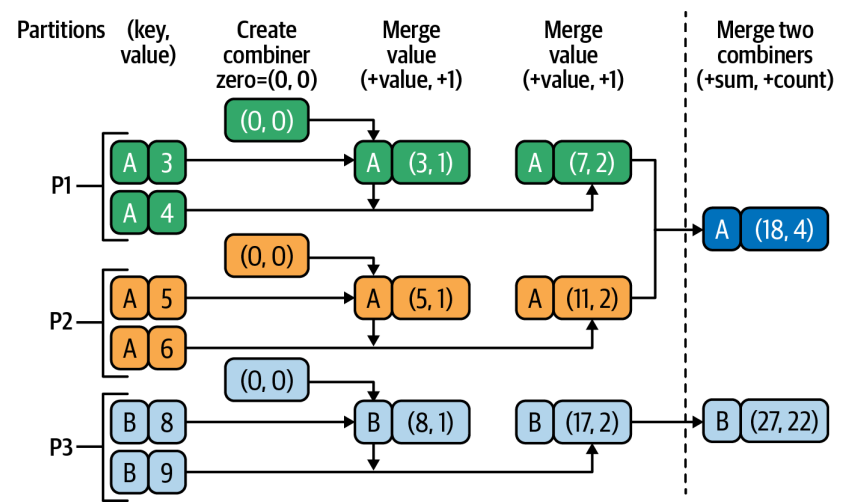

**Picture form the book Data Algorithms with Spark, by Mahmoud Parsian, O'Reilly Media, 2022

In [39]:
ratings = sc.parallelize([("A",3),("A",4),("A",5),("A",6),("B",8),("B",9),])
print("partitions\n",ratings.glom().collect())
sum_count = ratings.aggregateByKey((0.0, 0),
                (lambda C, V: (C[0]+V, C[1]+1)),
                (lambda C1, C2: (C1[0]+C2[0], C1[1]+C2[1]))
            )
print("result\n",sum_count.collect())

partitions
 [[('A', 3), ('A', 4), ('A', 5), ('A', 6), ('B', 8), ('B', 9)]]
result
 [('A', (18.0, 4)), ('B', (17.0, 2))]


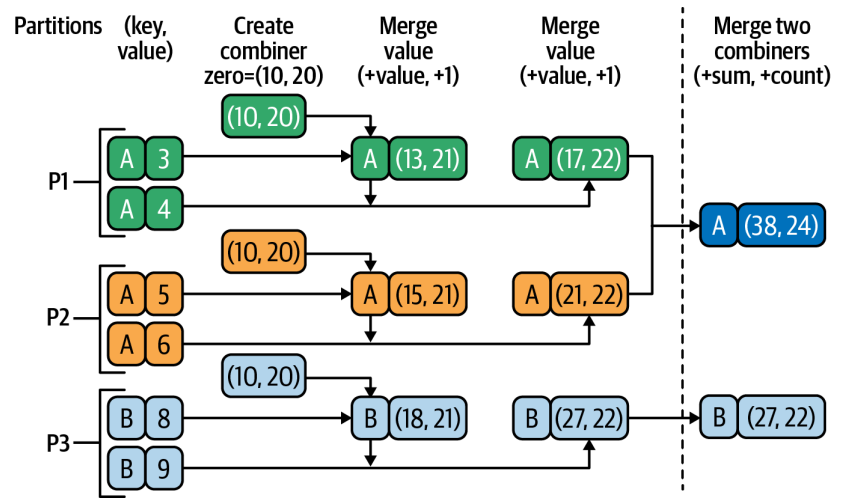

**Picture form the book Data Algorithms with Spark, by Mahmoud Parsian, O'Reilly Media, 2022

In [40]:
# Create a RDD with 3 partitions
ratings = sc.parallelize([("A",3),("A",4),("A",5),("A",6),("B",8),("B",9),],3)
print("partitions\n",ratings.glom().collect())
sum_count = ratings.aggregateByKey((0.0, 0),
                (lambda C, V: (C[0]+V, C[1]+1)),
                (lambda C1, C2: (C1[0]+C2[0], C1[1]+C2[1]))
            )
print("result\n",sum_count.collect())


partitions
 [[('A', 3), ('A', 4)], [('A', 5), ('A', 6)], [('B', 8), ('B', 9)]]
result
 [('B', (17.0, 2)), ('A', (18.0, 4))]


# Spark DataFrame repartition()
Unlike RDD, you can’t specify the partition/parallelism while creating DataFrame. 

Spark DataFrame repartition() method is used to increase or decrease the partitions.


In [25]:
b = [('Chris', 'Berliner', 5),('Paul', 'Amstel', 6), ('Peter', 'Bud Light', 9), ('John', 'Corona Extra', 6)]
df = spark.createDataFrame(b, ['drinker', 'beer', 'score'])
print(df.rdd.glom().collect())

[[Row(drinker='Chris', beer='Berliner', score=5), Row(drinker='Paul', beer='Amstel', score=6), Row(drinker='Peter', beer='Bud Light', score=9), Row(drinker='John', beer='Corona Extra', score=6)]]


In [29]:
df2 = df.repartition(4)
print(df2.rdd.glom().collect())

[[Row(drinker='Peter', beer='Bud Light', score=9)], [Row(drinker='Paul', beer='Amstel', score=6)], [Row(drinker='John', beer='Corona Extra', score=6)], [Row(drinker='Chris', beer='Berliner', score=5)]]
